# **Import Library That We Need**

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

# **Download Dataset From Kaggle**

In here we can use our account token/API kaggle in our Kaggle account.

In [2]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"willyho11","key":"8b714a4157df8205fddcca04810e62bf"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muttaqin1113/face-skin-type

Dataset URL: https://www.kaggle.com/datasets/muttaqin1113/face-skin-type
License(s): apache-2.0
 59% 33.0M/56.0M [00:00<00:00, 53.1MB/s]
100% 56.0M/56.0M [00:00<00:00, 74.1MB/s]


In [7]:
!unzip -q /content/face-skin-type.zip \
  && rm /content/face-skin-type.zip

#**Use splitfolders to Split Our Dataset Into 70% for Train, 20% for Validation, and 10% for Test**

In [8]:
!pip install split-folders

In [9]:
import splitfolders
input_folder='/content/skin2'

splitfolders.ratio(input_folder, output="Skin Type",
                   seed=42, ratio=(.7,.2,.1),
                  group_prefix=None)

Copying files: 1735 files [00:01, 1619.35 files/s]


# **Image Augmenation Process**

In [10]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 45,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.25,
                                   zoom_range = 0.5,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      shuffle = True)

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224),
                                                                shuffle=False)

  return train_generator, validation_generator

In [11]:
TRAINING_DIR = '/content/Skin Type/train'
VALIDATION_DIR = '/content/Skin Type/val'

In [12]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1211 images belonging to 4 classes.
Found 346 images belonging to 4 classes.


In [13]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(TRAINING_DIR,
                                             shuffle=True,
                                             image_size=(224,224))

Found 1211 files belonging to 4 classes.


In [14]:
class_names = train_dataset.class_names
print(class_names)

['berjerawat', 'berminyak', 'kering', 'normal']


In [15]:
model = tf.keras.models.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fifth convolutional block
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Sixth convolutional block
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Global Average Pooling layer
    tf.keras.layers.GlobalAveragePooling2D(),

    # Fully connected dense layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),

    # Output layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,953,412 (26.53 MB)

 Trainable params: 6,949,380 (26.51 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [16]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    verbose = 2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 - 55s - 1s/step - accuracy: 0.3394 - loss: 1.9025 - val_accuracy: 0.2486 - val_loss: 1.3991
Epoch 2/100
38/38 - 19s - 499ms/step - accuracy: 0.3790 - loss: 1.5972 - val_accuracy: 0.2486 - val_loss: 1.5592
Epoch 3/100
38/38 - 18s - 466ms/step - accuracy: 0.4203 - loss: 1.4473 - val_accuracy: 0.2486 - val_loss: 1.7986
Epoch 4/100
38/38 - 21s - 564ms/step - accuracy: 0.4401 - loss: 1.3967 - val_accuracy: 0.2486 - val_loss: 1.7549
Epoch 5/100
38/38 - 17s - 455ms/step - accuracy: 0.4476 - loss: 1.3248 - val_accuracy: 0.2486 - val_loss: 2.2163
Epoch 6/100
38/38 - 22s - 582ms/step - accuracy: 0.4905 - loss: 1.2211 - val_accuracy: 0.2486 - val_loss: 2.0649
Epoch 7/100
38/38 - 17s - 455ms/step - accuracy: 0.4633 - loss: 1.3280 - val_accuracy: 0.2486 - val_loss: 2.3263
Epoch 8/100
38/38 - 18s - 483ms/step - accuracy: 0.4756 - loss: 1.2182 - val_accuracy: 0.2486 - val_loss: 2.8265
Epoch 9/100
38/38 - 20s - 515ms/step - accuracy: 0.4847 - loss: 1.2219 - val_accuracy: 0.2486 - val_loss: 2.070

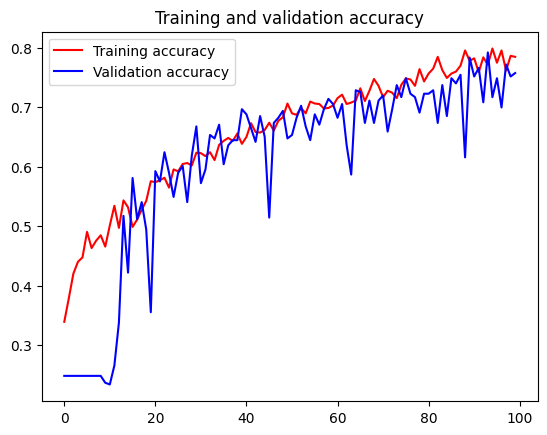

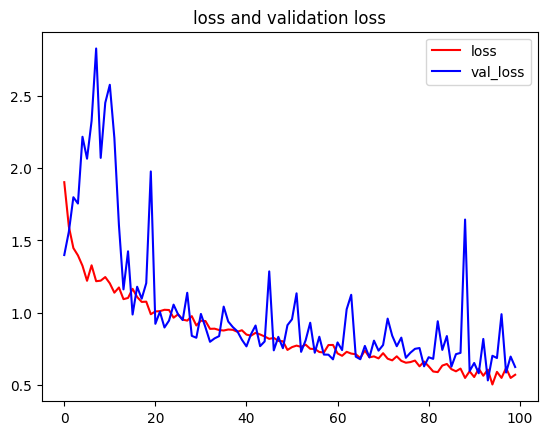

<Figure size 640x480 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# **Transfer Learning InceptionV3**

In [19]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-11-30 09:57:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c06::cf, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   308MB/s    in 0.3s    

2024-11-30 09:57:20 (308 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [20]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [21]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(224,224, 3))

  #pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layers in pre_trained_model.layers:
    layers.trainable = False



  return pre_trained_model

In [22]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 111, 111, 32)   │             96 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 109, 109, 32)   │             96 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 109, 109, 64)   │            192 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 54, 54, 80)     │            240 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 52, 52, 192)    │            576 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.95 and logs.get('val_accuracy')>=0.95):
      print("\nReached 95.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [24]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed4')
  print('last layer output shape: ', last_desired_layer.output.shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

In [25]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  <KerasTensor shape=(None, 12, 12, 768), dtype=float32, sparse=False, name=keras_tensor_156>


In [26]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.models.functional.Functional'>


In [27]:
x = keras.layers.GlobalAveragePooling2D()(last_output)
x = keras.layers.Dense (256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense (4, activation='softmax')(x)
model2 = Model(pre_trained_model.input, x)
model2.summary()

model2.compile(optimizer=keras.optimizers.Adam(0.0001),  # Low learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 111, 111, 32)   │             96 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 109, 109, 32)   │             96 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 109, 109, 64)   │            192 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 54, 54, 80)     │            240 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 52, 52, 192)    │            576 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 3,643,812 (13.90 MB)

 Trainable params: 197,892 (773.02 KB)

 Non-trainable params: 3,445,920 (13.15 MB)

In [28]:
callbacks = myCallback()
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks = [callbacks]
                    )

Epoch 1/100
38/38 - 41s - 1s/step - accuracy: 0.2692 - loss: 1.4245 - val_accuracy: 0.4191 - val_loss: 1.3117
Epoch 2/100
38/38 - 22s - 573ms/step - accuracy: 0.3526 - loss: 1.3363 - val_accuracy: 0.4971 - val_loss: 1.2368
Epoch 3/100
38/38 - 18s - 461ms/step - accuracy: 0.4030 - loss: 1.2944 - val_accuracy: 0.6243 - val_loss: 1.1713
Epoch 4/100
38/38 - 17s - 444ms/step - accuracy: 0.4715 - loss: 1.2385 - val_accuracy: 0.6734 - val_loss: 1.1178
Epoch 5/100
38/38 - 17s - 441ms/step - accuracy: 0.5004 - loss: 1.1925 - val_accuracy: 0.6763 - val_loss: 1.0699
Epoch 6/100
38/38 - 18s - 467ms/step - accuracy: 0.5252 - loss: 1.1593 - val_accuracy: 0.7023 - val_loss: 1.0280
Epoch 7/100
38/38 - 20s - 520ms/step - accuracy: 0.5549 - loss: 1.1280 - val_accuracy: 0.6792 - val_loss: 0.9913
Epoch 8/100
38/38 - 19s - 492ms/step - accuracy: 0.5830 - loss: 1.0911 - val_accuracy: 0.6965 - val_loss: 0.9500
Epoch 9/100
38/38 - 19s - 490ms/step - accuracy: 0.6036 - loss: 1.0542 - val_accuracy: 0.6792 - val

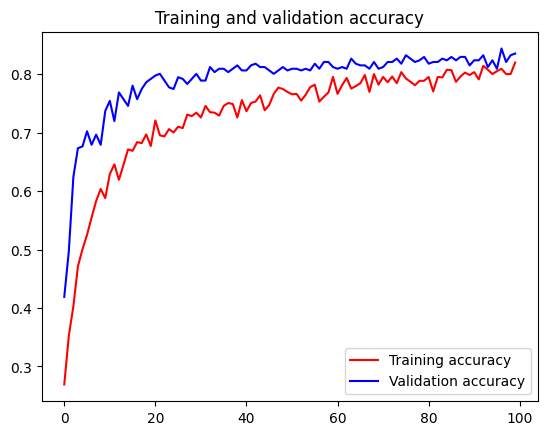

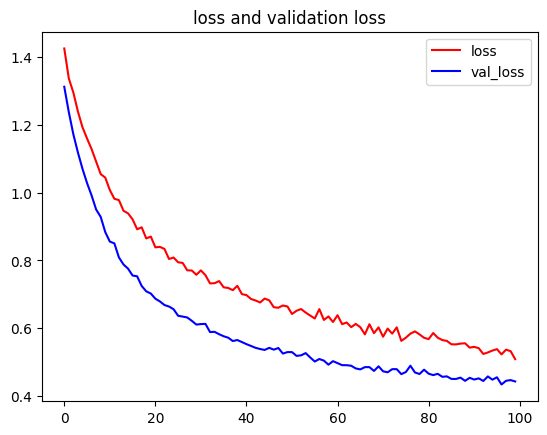

<Figure size 640x480 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


# **Fine Tuning Process**

In [30]:
from tensorflow import keras
pre_trained_model.trainable = True
#model2.summary()

model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
                loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy']
)


model2.fit(train_generator,
           validation_data=validation_generator,
           epochs = 50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 594ms/step - accuracy: 0.8232 - loss: 0.5040 - val_accuracy: 0.8353 - val_loss: 0.4379
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.8194 - loss: 0.5212 - val_accuracy: 0.8382 - val_loss: 0.4346
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 382ms/step - accuracy: 0.8328 - loss: 0.4829 - val_accuracy: 0.8353 - val_loss: 0.4357
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - accuracy: 0.8225 - loss: 0.5040 - val_accuracy: 0.8410 - val_loss: 0.4328
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.7991 - loss: 0.5717 - val_accuracy: 0.8353 - val_loss: 0.4355
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.7969 - loss: 0.5302 - val_accuracy: 0.8353 - val_loss: 0.4344
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 379ms/step - accuracy: 0.8123 - loss: 0.5080 - val_accuracy: 0.8295 - val_loss: 0.4362
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 379ms/step - accuracy: 0.8272 - loss: 0.4991 - val_accuracy: 0.838

# **Testing**

Saving berjerawat202810829.png to berjerawat202810829.png
Saving berminyak202810829.png to berminyak202810829.png
Saving kering202810329.png to kering202810329.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


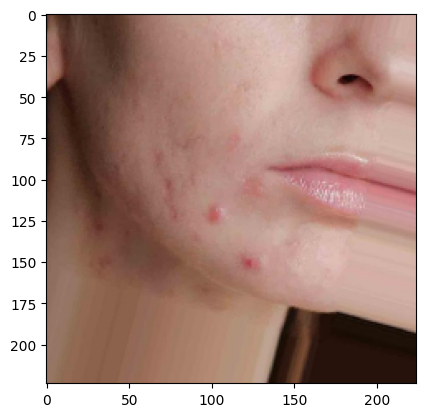

berjerawat: 95.12%
berminyak: 0.28%
kering: 4.50%
normal: 0.11%

Result:
berjerawat: 95.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


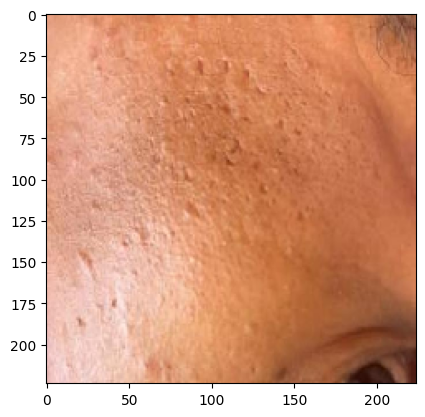

berjerawat: 14.73%
berminyak: 64.41%
kering: 11.64%
normal: 9.23%

Result:
berminyak: 64.41%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


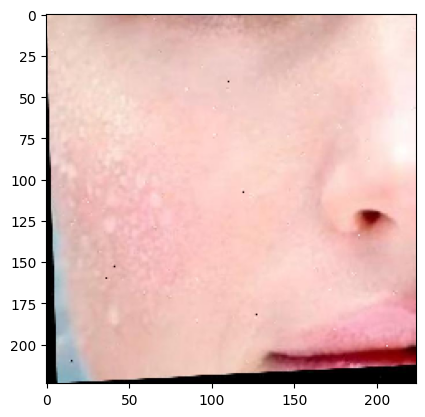

berjerawat: 0.54%
berminyak: 0.09%
kering: 99.31%
normal: 0.06%

Result:
kering: 99.31%


In [31]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

labels = train_generator.class_indices.keys()
uploaded = files.upload()

for paths in uploaded.keys():
    path = paths
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    images = np.vstack([x])
    proba = model2.predict(images)[0]
    maxx = proba.max()
    plt.imshow(img)
    plt.show()

    for (label, p) in zip(labels, proba):
        print("{}: {:.2f}%".format(label, p * 100))

    max_index = np.argmax(proba)
    max_proba = proba[max_index]
    max_label = list(labels)[max_index]

    if max_proba >= 0.5:
        print('\nResult:')
        print("{}: {:.2f}%".format(max_label, max_proba * 100))
    else:
        print('\nResult:')
        print('Hasil tidak ditemukan!')

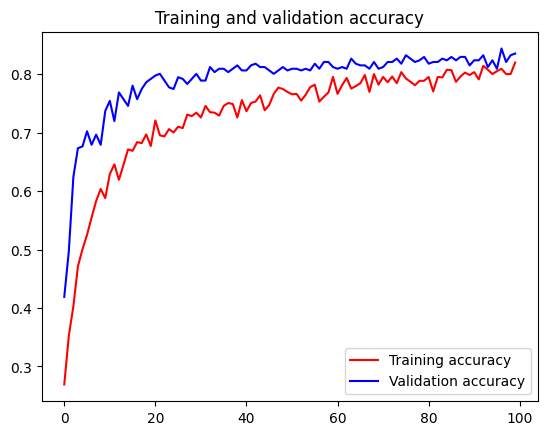

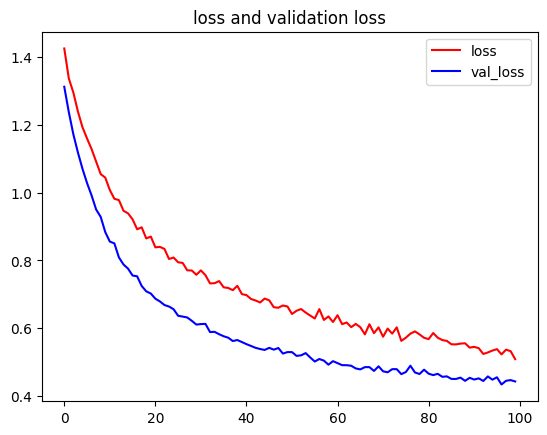

<Figure size 640x480 with 0 Axes>

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


# **Saving Model**

In [32]:
#Save the model in TensorFlow format
model2.save("my_model.h5")

In [33]:
import tensorflow as tf

# Load the TensorFlow model
model = tf.keras.models.load_model('/content/my_model.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpfux1uk4x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140674083896160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084003984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084006096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084001696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084009792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084009440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084009088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084008560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084005744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674084029536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1406740840078